In [ ]:

"""
Fuel Consumption Imputation for Norwegian Passenger Cars
=======================================================

Purpose
-------
This script imputes missing fuel consumption values for Norwegian passenger
cars using technical and regulatory information from the REGTEK vehicle
registry. The imputed fuel consumption values are intended for downstream
use in emissions modeling (e.g. CO₂).

The model is trained only on vehicles with observed fuel consumption and is
then suitable for imputing values for vehicles where this information is
missing.

Inputs
------
- REGTEK vehicle registry:
    * Observed fuel consumption (may be missing or inconsistently formatted)
    * Engine characteristics (power, displacement)
    * Vehicle mass and dimensions
    * Drivetrain configuration
    * Fuel type codes
    * Euro emission standard
    * Body type and brand information

Method
------
1. Restrict REGTEK to passenger cars only (vehicle group 101).
2. Clean numeric feature variables using a generic numeric cleaner.
3. Clean fuel consumption (target variable) using a dedicated routine that
   removes units and registry-specific formatting.
4. Decode primary fuel type from REGTEK fuel codes.
5. Remove vehicles with invalid or implausible fuel consumption values
   (≤ 0 or ≥ 50 L/100 km).
6. Engineer physically meaningful features:
    - Power-to-weight ratio
    - Vehicle size proxy (length × width)
7. Split the data into training and hold-out validation sets.
8. Construct a preprocessing and modeling pipeline that:
    - Imputes missing numeric values using the median
    - Imputes missing categorical values using the most frequent category
    - One-hot encodes categorical variables
9. Train a gradient boosting regression model
10. Evaluate model performance on the hold-out validation set using MAE and
    RMSE and visualize predicted vs actual fuel consumption.

Outputs
-------
- fuel_consumption_estimated.parquet:
    REGTEK dataset augmented with model-based estimates of fuel consumption
    for vehicles in the validation set (and optionally for all vehicles if
    applied downstream).

"""

In [ ]:
# %%
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.model_selection import GridSearchCV


# ============================================================
# PATHS
# ============================================================
REGTEK_PATH = r"C:\Users\s15832\Documents\Project\weightproject\Data\REGTEK_data_25.02.2025.parquet"
OUTPUT_PATH = r"C:\Users\s15832\Documents\Project\weightproject\fuel_consumption_estimated.parquet"


In [14]:
# ============================================================
# HELPERS
# ============================================================
def fast_clean_numeric(series: pd.Series) -> pd.Series:
    """
    Generic numeric cleaner for FEATURES.
    """
    s = (
        series.astype(str)
        .str.replace(",", ".", regex=False)
        .str.strip()
        .replace(["", ".", "-", "nan", "na", "none", "null"], np.nan)
    )
    return pd.to_numeric(s, errors="coerce")


def clean_fuel_consumption(series: pd.Series) -> pd.Series:
    """
    Dedicated cleaner for TARGET (fuel consumption).
    Handles units and registry formatting.
    """
    s = series.astype(str).str.lower()

    # remove units / text
    s = s.str.replace("l/100km", "", regex=False)
    s = s.str.replace("km/l", "", regex=False)

    # normalize decimals
    s = s.str.replace(",", ".", regex=False)

    # strip junk
    s = s.str.strip()
    s = s.replace(["", ".", "-", "nan", "na", "none", "null"], np.nan)

    return pd.to_numeric(s, errors="coerce")


fuel_map = {
    1: "petrol", 2: "diesel", 3: "paraffin", 4: "gas", 5: "electric",
    6: "hydrogen", 7: "petrol_hybrid_old", 8: "diesel_hybrid_old",
    9: "other", 10: "biodiesel", 11: "biopetrol",
    12: "lpg", 13: "cng", 14: "methanol", 15: "ethanol",
    16: "lpg_A", 17: "lpg_B", 18: "cng_20", 19: "cng_25",
    20: "compressed_air",
}


def decode_primary_fuel(series: pd.Series) -> pd.Series:
    codes = series.astype(str).str.split(",", n=1, expand=True)[0]
    fuel_code = pd.to_numeric(codes, errors="coerce")
    return fuel_code.map(fuel_map).fillna("other")

In [15]:
# ============================================================
# LOAD + FILTER
# ============================================================
df = pd.read_parquet(REGTEK_PATH)

# Passenger cars only
df = df[df["TEKN_KJTGRP"] == "101"].copy()
print(f"REGTEK passenger cars: {len(df):,}")


# ============================================================
# RENAME COLUMNS (only what we use)
# ============================================================
COLUMN_MAP = {
    "TEKN_MOTORYTELSE": "engine_power_kw",
    "TEKN_SLAGVOLUM": "engine_displacement_cc",
    "TEKN_EGENVEKT": "curb_weight_kg",
    "TEKN_TOTVEKT": "gross_weight_kg",
    "TEKN_VOGNTOGVEKT": "gross_train_weight_kg",
    "TEKN_LENGDE": "vehicle_length_mm",
    "TEKN_BREDDE": "vehicle_width_mm",
    "TEKN_ANTALL_DORER": "number_of_doors",
    "TEKN_SITTEPLASSER_TOTALT": "number_of_seats",
    "TEKN_AKSLER": "number_of_axles",
    "TEKN_AKSLER_DRIFT": "driven_axles",
    "TEKN_GIRKASSE": "gearbox_type",
    "TEKN_HYBRID": "is_hybrid",
    "TEKN_HYBRID_KATEGORI": "hybrid_category",
    "TEKN_KAROSSERITYPE": "body_type",
    "TEKN_MERKE": "brand",
    "TEKN_DRIVSTOFF": "fuel_code",
    "TEKN_DRIVSTOFF_FORBRUK": "fuel_consumption",
    "TEKN_EURONORM_NY": "euro_standard",
}

df = df.rename(columns=COLUMN_MAP)


REGTEK passenger cars: 7,121,936


In [16]:
# ============================================================
# FEATURE SETUP
# ============================================================
target = "fuel_consumption"

numeric_features = [
    "engine_power_kw",
    "engine_displacement_cc",
    "curb_weight_kg",
    "gross_weight_kg",
    "gross_train_weight_kg",
    "vehicle_length_mm",
    "vehicle_width_mm",
    "number_of_doors",
    "number_of_seats",
    "number_of_axles",
    "driven_axles",
]

categorical_features = [
    "fuel_code",
    "gearbox_type",
    "is_hybrid",
    "hybrid_category",
    "body_type",
    "brand",
    "euro_standard",
]

df_model = df[numeric_features + categorical_features + [target]].copy()

In [17]:
# ============================================================
# CLEAN DATA
# ============================================================
# Clean numeric FEATURES
for col in numeric_features:
    df_model[col] = fast_clean_numeric(df_model[col])

# Clean TARGET separately (CRITICAL FIX)
df_model[target] = clean_fuel_consumption(df_model[target])

# Decode fuel
df_model["fuel_type"] = decode_primary_fuel(df_model["fuel_code"])
df_model = df_model.drop(columns=["fuel_code"])

categorical_features.remove("fuel_code")
categorical_features.append("fuel_type")

In [18]:
# ============================================================
# DROP INVALID TARGETS
# ============================================================
before = len(df_model)
# (> 0 and < 50, assuming L/100 km)
df_model = df_model[(df_model[target] > 0) & (df_model[target] < 50)]
print(f"Dropped rows with invalid or missing target: {before - len(df_model):,}")

Dropped rows with invalid or missing target: 4,487,526


In [19]:
# ============================================================
# FEATURE ENGINEERING
# ============================================================

# Power-to-weight ratio:
# Tells the model how much engine power is available per kg of vehicle.
# Strong predictor of fuel consumption.
df_model["power_to_weight"] = (
    df_model["engine_power_kw"] / df_model["curb_weight_kg"]
)

# Vehicle size proxy:
# Approximates overall vehicle size using length × width.
# Larger vehicles generally consume more fuel.
df_model["size_proxy"] = (
    df_model["vehicle_length_mm"] * df_model["vehicle_width_mm"]
)

# Register engineered features as numeric inputs for the model
numeric_features += ["power_to_weight", "size_proxy"]

# Replace infinities (e.g., division by zero or missing weight)
# with NaN so the model can handle them safely via imputation
df_model.replace([np.inf, -np.inf], np.nan, inplace=True)


In [20]:
# ============================================================
# TRAIN / VALIDATION SPLIT
# ============================================================
X = df_model[numeric_features + categorical_features]
y = df_model[target]

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42
)


In [21]:
# ============================================================
# PIPELINE
# ============================================================

# Numeric feature processing:
# - Keeps all rows even if some numeric values are missing
# - Replaces missing numbers with the median (robust to outliers)
numeric_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
])

# Categorical feature processing:
# - Fills missing categories with the most common value
# - One-hot encodes categories so the model can use them
# - Ignores unseen categories at prediction time
# - Outputs dense arrays (required by HistGradientBoosting)
categorical_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False)),
])

# Combine numeric and categorical pipelines
# Each transformer is applied only to its own column set
preprocess = ColumnTransformer([
    ("num", numeric_transformer, numeric_features),
    ("cat", categorical_transformer, categorical_features),
])

# Gradient boosting regression model:
# - Captures non-linear relationships
# - Depth and learning rate balance bias vs variance
model = HistGradientBoostingRegressor(
    max_depth=6,
    learning_rate=0.08,
    max_iter=400,
    random_state=42
)

# Full pipeline:
# - Preprocessing and model are chained together
# - Ensures identical transformations during training and prediction
pipe = Pipeline([
    ("preprocess", preprocess),
    ("model", model),
])


MAE:  0.1993
RMSE: 0.3189


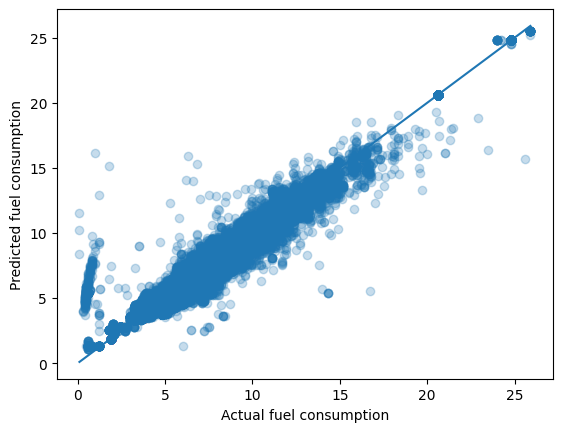

In [22]:
# ============================================================
# TRAIN
# ============================================================
pipe.fit(X_train, y_train)


# ============================================================
# EVALUATE
# ============================================================
y_pred = pipe.predict(X_val)

mae = mean_absolute_error(y_val, y_pred)
rmse = np.sqrt(mean_squared_error(y_val, y_pred))

print(f"MAE:  {mae:.4f}")
print(f"RMSE: {rmse:.4f}")

plt.scatter(y_val, y_pred, alpha=0.25)
plt.xlabel("Actual fuel consumption")
plt.ylabel("Predicted fuel consumption")
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()])
plt.show()

